<a href="https://colab.research.google.com/github/hebertgo/Prueba_Data_Science_Davivienda/blob/master/01_hebertgomez/CleanDataAppraisal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Consideraciones Iniciales**

In [ ]:
#Instalar librerías
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.9 MB/s eta 0:00:00


In [40]:
#Importaciones
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np
import ftfy
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Preparación y limpieza de datos

In [61]:
file_path = 'train_precios_vivienda.csv'  # Ruta del archivo CSV
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)

# Eliminar la columna en la primera posición
df.drop(df.columns[0], axis=1, inplace=True)
df = df.drop('fecha_aprobación', axis=1)

# Función para identificar, corregir texto mal codificado y convertir a minúsculas
def correct_encoding(text):
    """
    Función que verifica y corrige texto mal codificado en formato 'utf-8' y lo convierte a minúsculas.

    Args:
        text (str): Cadena de texto que se desea corregir.

    Returns:
        str: Texto corregido y convertido a minúsculas, eliminando espacios adicionales.
             Si el valor no es una cadena de texto, se devuelve el valor original.
    """
    if isinstance(text, str) and any(char in text for char in 'Ã©Ã¡Ã­Ã³ÃºÃ±â'):
        text = ftfy.fix_text(text)
    if isinstance(text, str):  # Verifica si el valor es una cadena de texto
        return text.lower().strip()  # Convierte a minúsculas y elimina espacios
    else:
        return text  # Devuelve el valor original si no es una cadena de texto


# Aplicar la corrección y conversión a minúsculas a todas las columnas de tipo 'object' (string)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].apply(correct_encoding)

# Eliminar las filas donde valor_total_avaluo sea 0
df = df.dropna(subset=['valor_total_avaluo'])
df = df[df['valor_total_avaluo'] != 0]

# Eliminar puntos de la columna 'valor_total_avaluo'
df['valor_total_avaluo'] = df['valor_total_avaluo'].str.replace(',', '.')

# Eliminar columnas específicas por índice
columns_to_drop = [54, 158, 166, 167, 168, 169, 183, 184, 186]
df.drop(df.columns[columns_to_drop], axis=1, inplace=True)

# Guardar el DataFrame limpio a un nuevo archivo CSV
df.to_csv('train_precios_vivienda_clean.csv', index=False)

print("Datos limpiados, normalizados, convertidos a minúsculas y valores 'si' y 'no' convertidos a 1 y 0 automáticamente.")



Datos limpiados, normalizados, convertidos a minúsculas y valores 'si' y 'no' convertidos a 1 y 0 automáticamente.


In [ ]:
df.head()

,id,objeto,motivo,proposito,tipo_avaluo,tipo_credito,tipo_subsidio,departamento_inmueble,municipio_inmueble,barrio,...,valor_area_construccion,area_otros,valor_area_otros,area_libre,valor_area_libre,valor_total_avaluo,valor_uvr,valor_avaluo_en_uvr,Longitud,Latitud
0,5896,remate,remates,garantía hipotecaria,remates,vivienda,NaN,valle del cauca,tulua,victoria,...,"81968750,00",0,0,0,0,145318750.00,2522304,"576134,95",0.000000,0.000000
1,10570,originación,crédito hipotecario de vivienda,garantía hipotecaria,hipotecario,vivienda,NaN,quindío,armenia,sector clinicas,...,0,157,78500000,no,0,713986654,257.23250000000002,2775647.14,-75.661152,4.544027
2,14600,originación,crédito hipotecario de vivienda,garantía hipotecaria,hipotecario,vivienda,NaN,antioquia,medellin,robledo pilarica,...,0,0,0,si,0,270500000,259.4264,1042684.94,-75.584116,6.277020
3,5967,originación,crédito hipotecario de vivienda,garantía hipotecaria,hipotecario,vivienda,vis,cundinamarca,soacha,ciudad verde,...,0,0,0,no,0,84840000.00,252245,"336339,67",0.000000,0.000000
4,15814,originación,crédito hipotecario de vivienda,garantía hipotecaria,hipotecario,vivienda,vis,meta,granada,bulevar etapa ii,...,69306400,0,0,0,0,96346400,259.72770000000003,370951.58,-73.712370,3.565757


## Transformación y Codificación de Datos Categóricos en el DataFrame

In [78]:
# Cargar el DataFrame limpio desde el archivo 'train_precios_vivienda_clean.csv'
file_path_clean = 'train_precios_vivienda_clean.csv'
df_clean = pd.read_csv(file_path_clean, low_memory=False)

# Identificar las columnas categóricas (de tipo 'object')
categorical_cols = df_clean.select_dtypes(include=['object']).columns

# Función para asignar un valor numérico a cada string
def encode_column(column):
    """
    Función que asigna un valor numérico único a cada cadena de texto en una columna.

    Args:
        column (Series): Columna de tipo 'object' que se desea codificar.

    Returns:
        Series: Columna codificada numéricamente, donde cada valor único de la columna
                original tiene un valor numérico único asignado.
    """
    # Crear un diccionario para asignar valores únicos
    unique_values = column.dropna().unique()
    value_to_num = {val: num for num, val in enumerate(unique_values)}
    # Mapear los valores de la columna según el diccionario
    return column.map(value_to_num)

# Aplicar la función 'encode_column' a cada columna categórica
for col in categorical_cols:
    df_clean[col] = encode_column(df_clean[col].astype(str))

# Guardar el DataFrame transformado a un nuevo archivo CSV
df_clean.to_csv('train_precios_vivienda_encoded_manual.csv', index=False)





In [79]:
df_clean
print(df_clean['valor_total_avaluo'].dtype)

float64


# **Preprocesamiento de Datos y Análisis de Correlación**

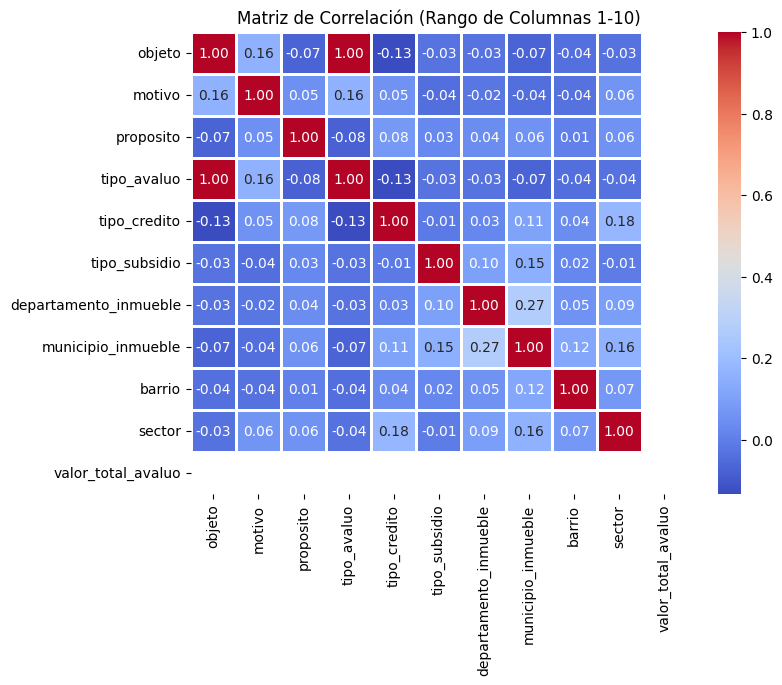

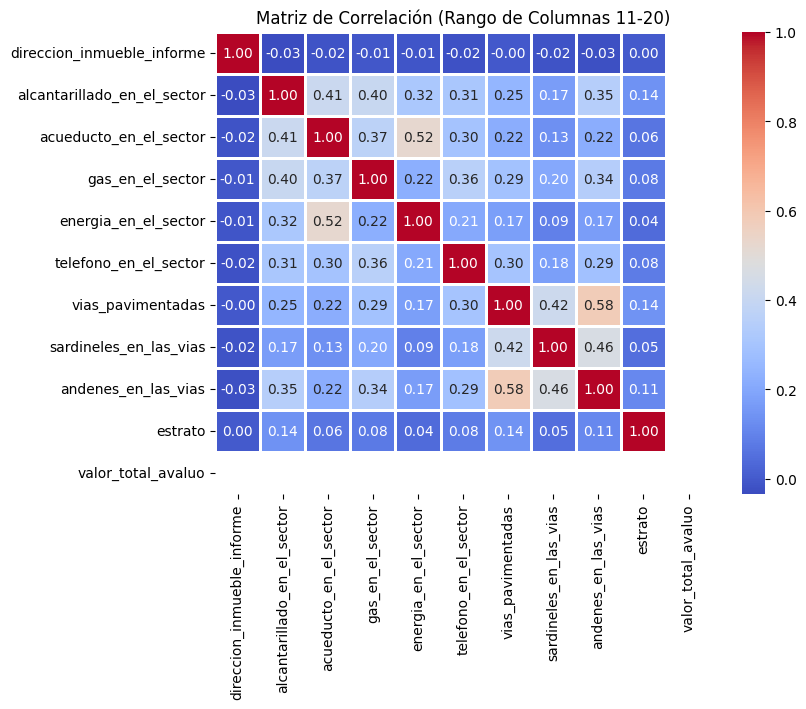

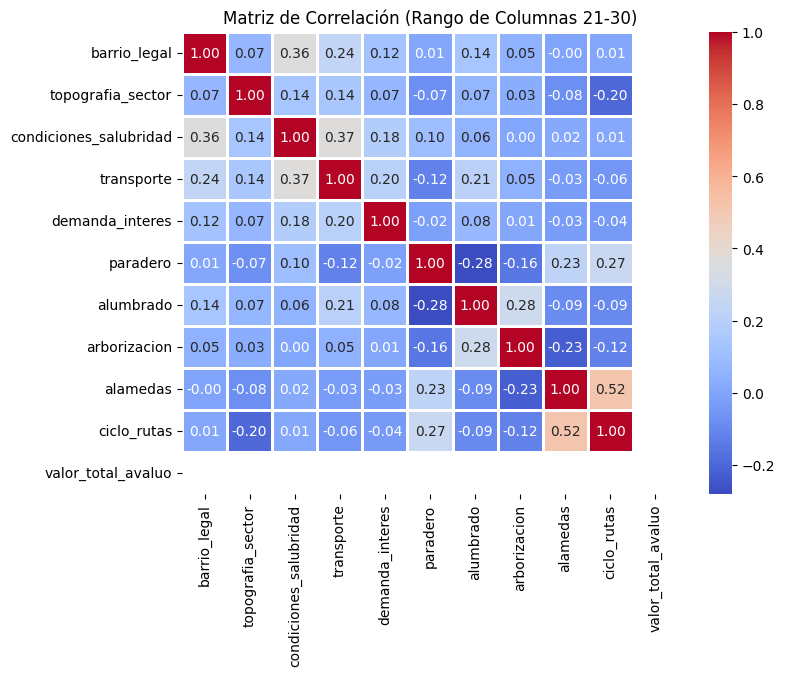

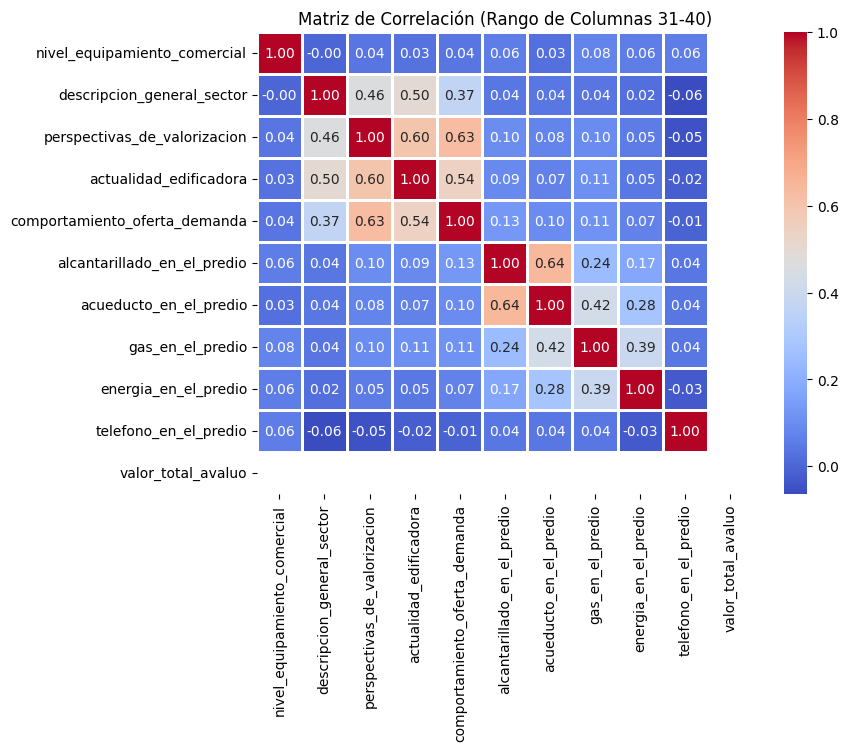

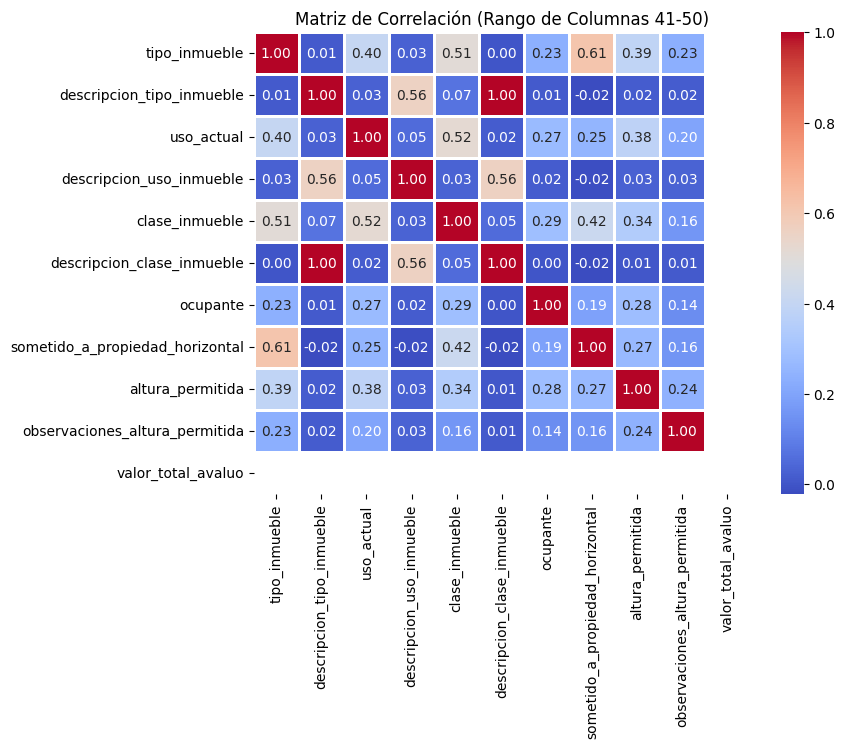

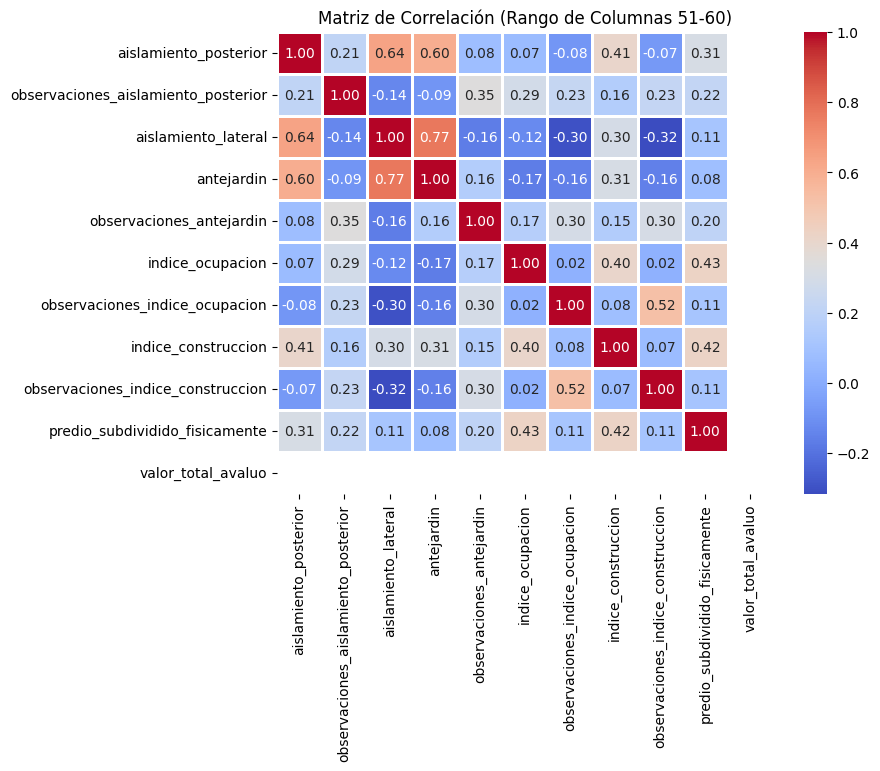

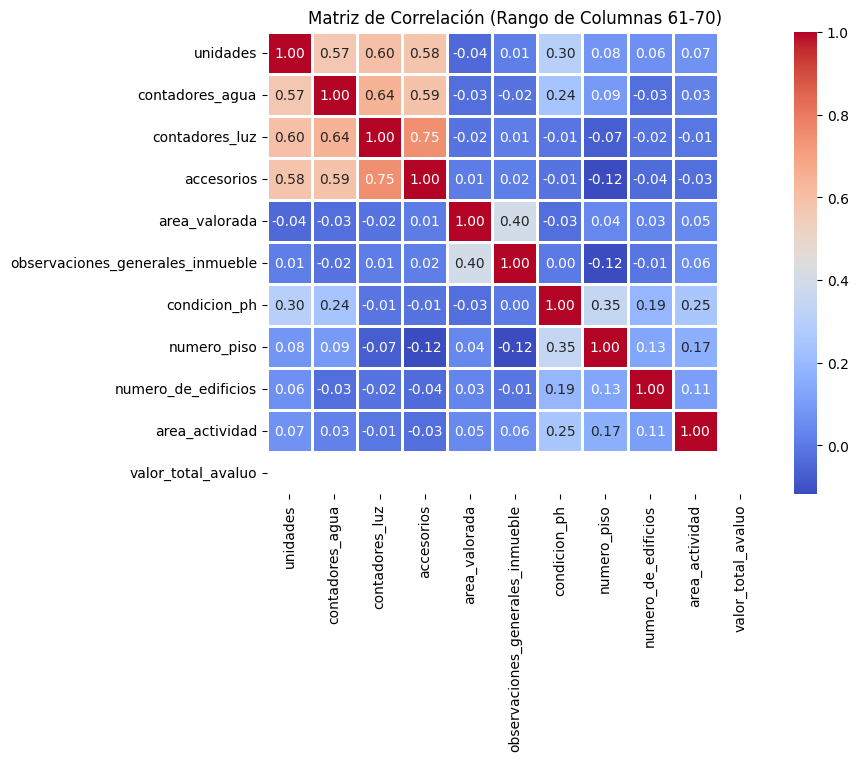

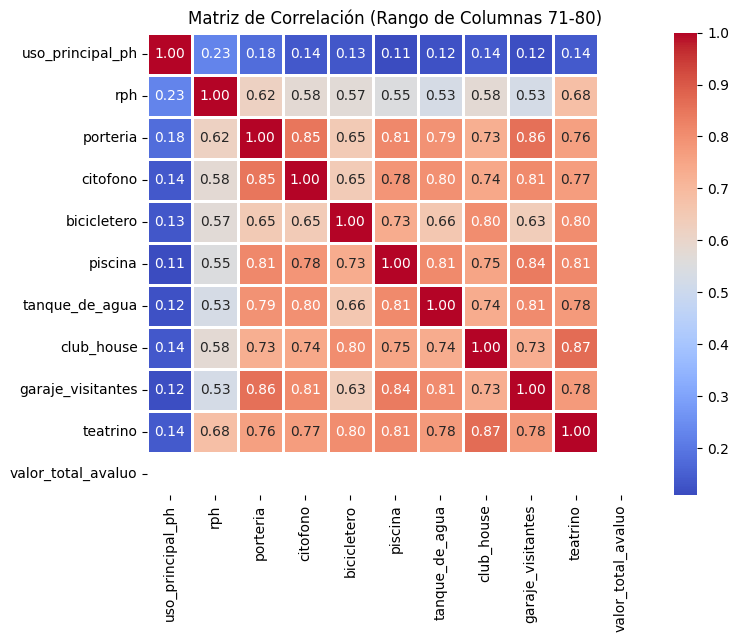

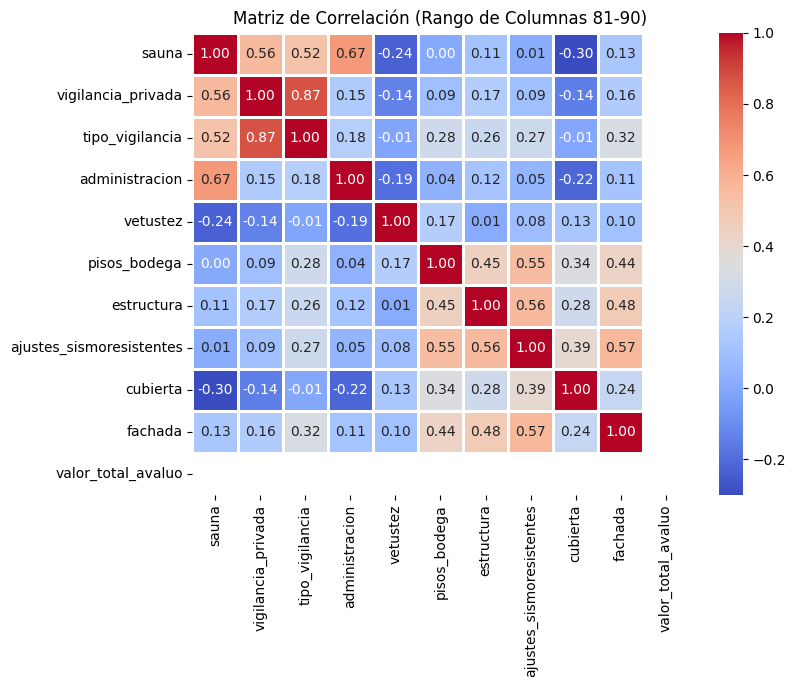

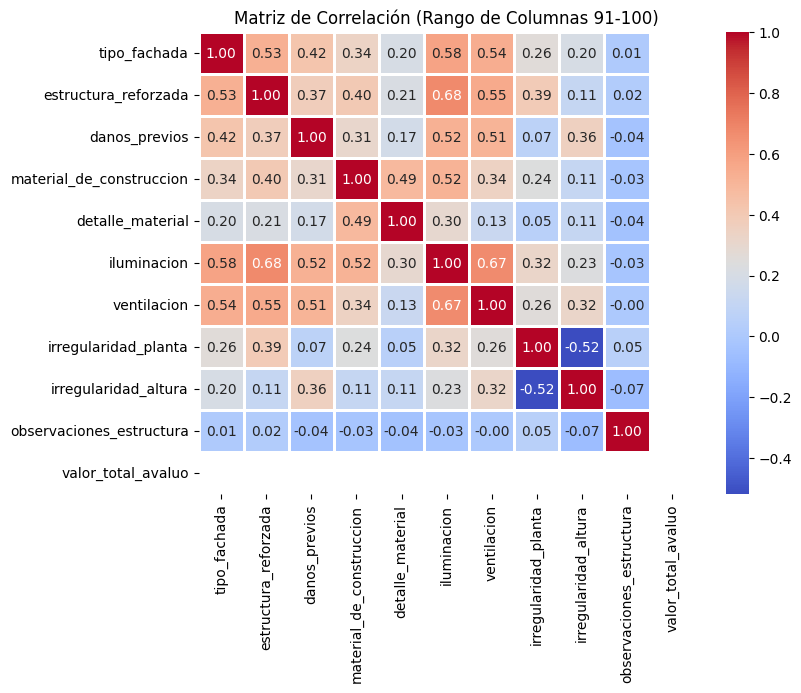

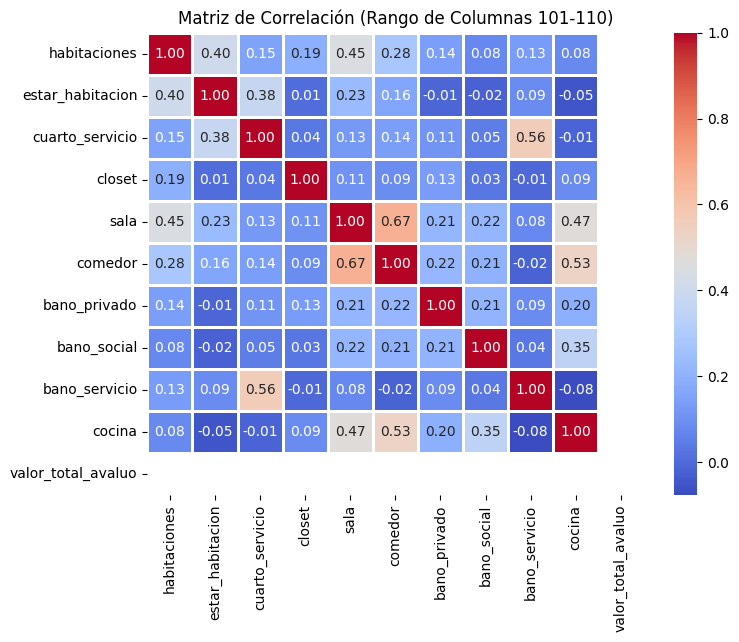

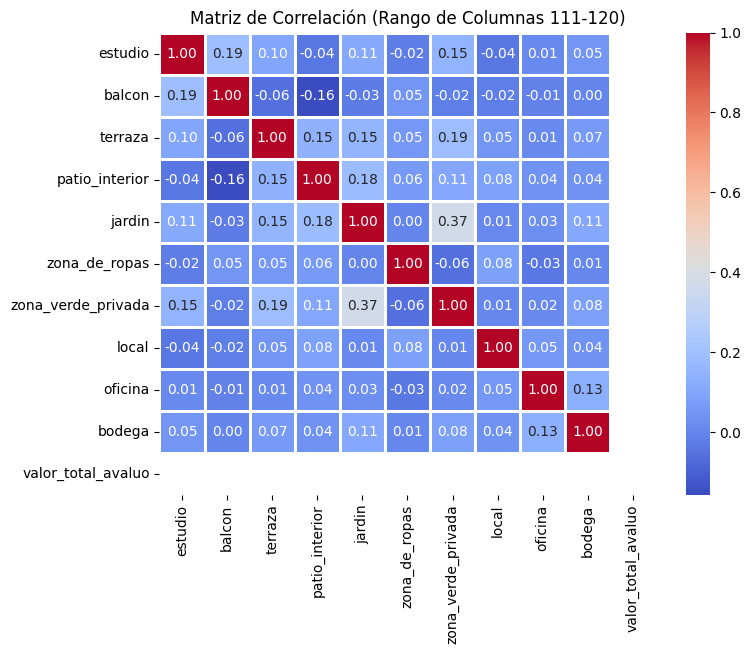

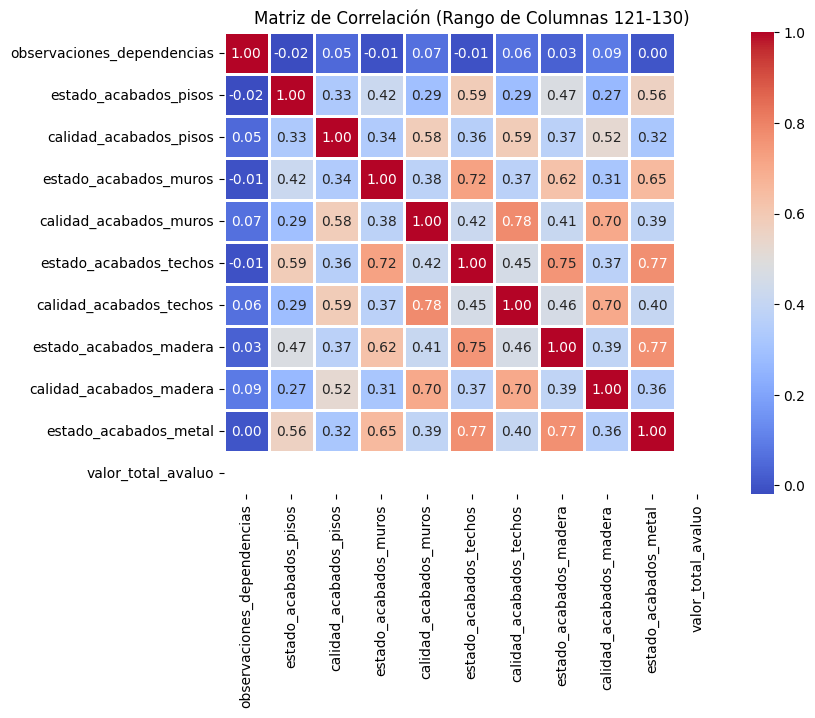

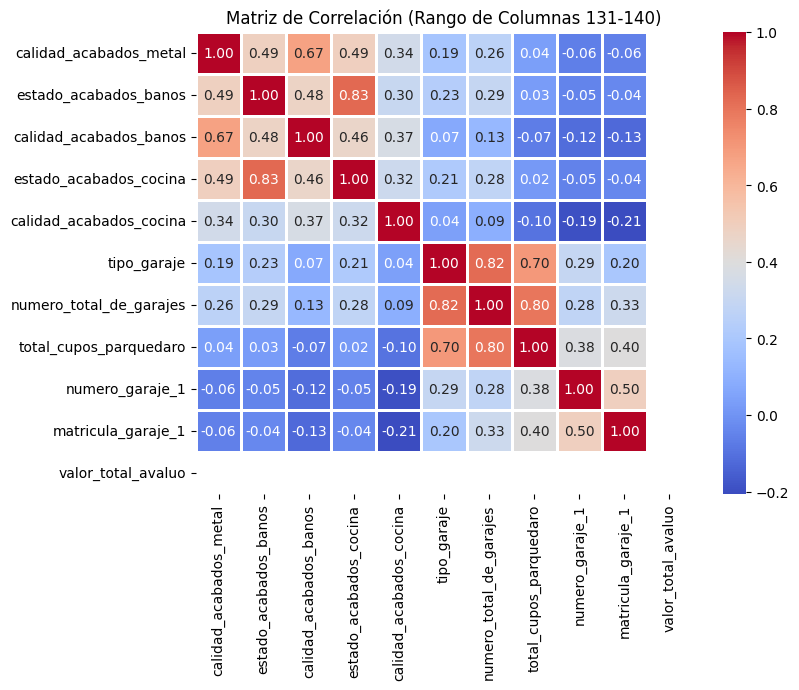

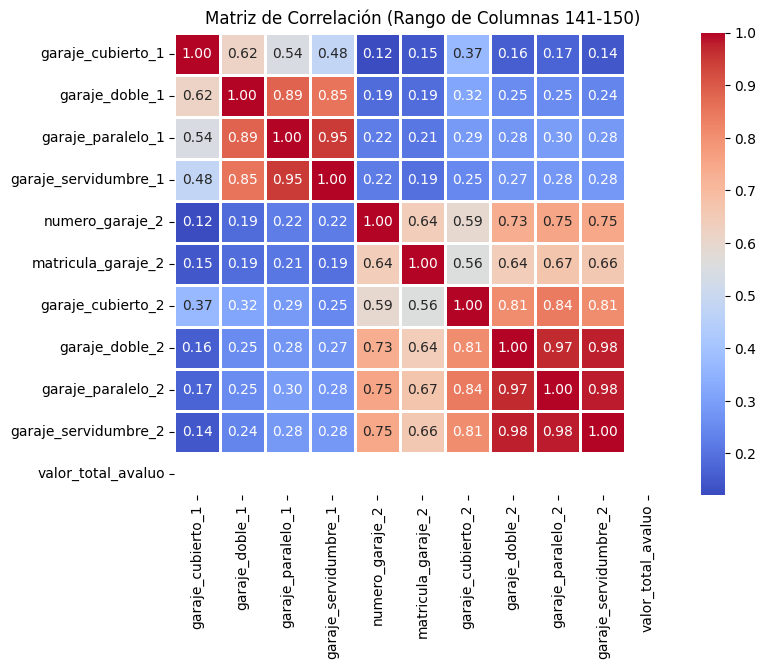

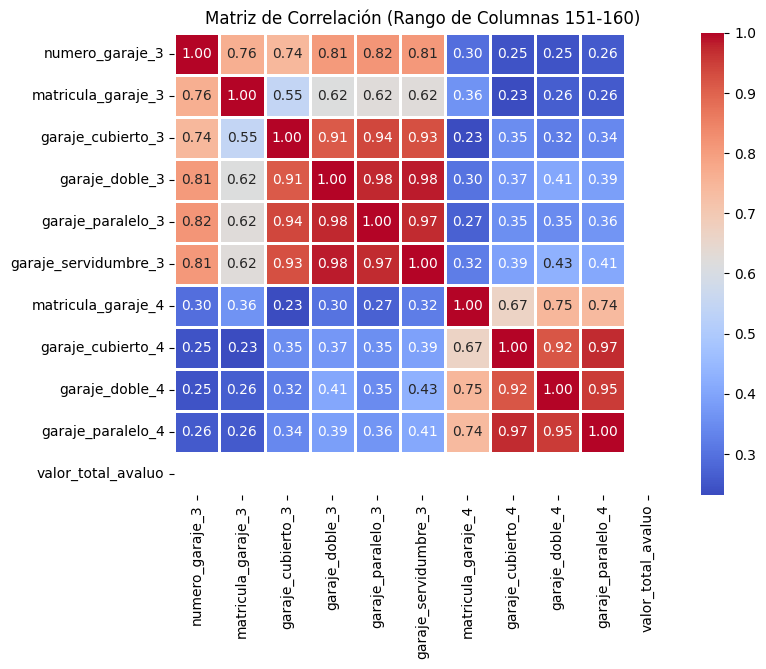

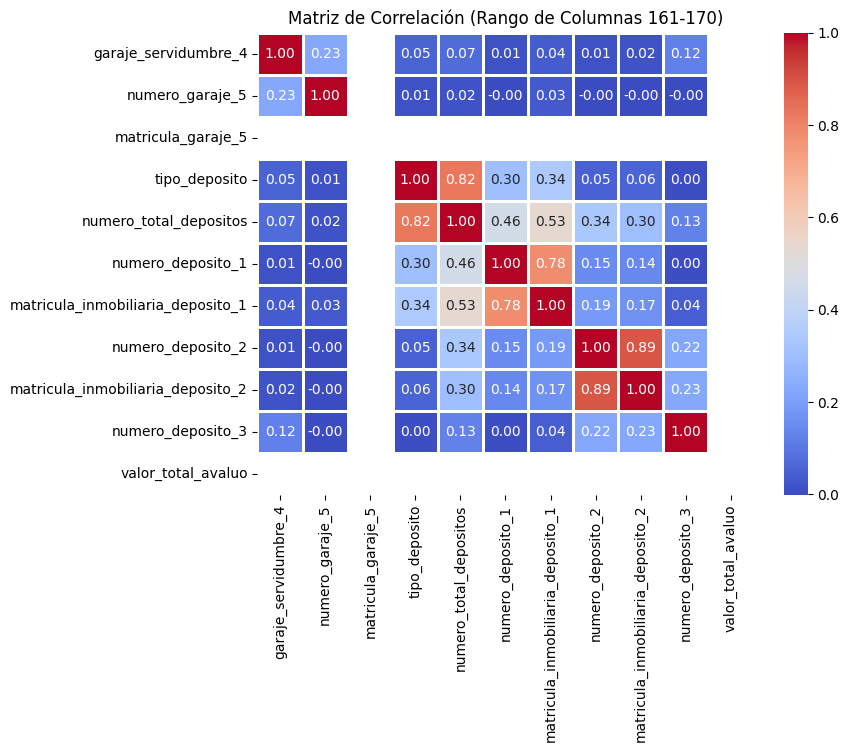

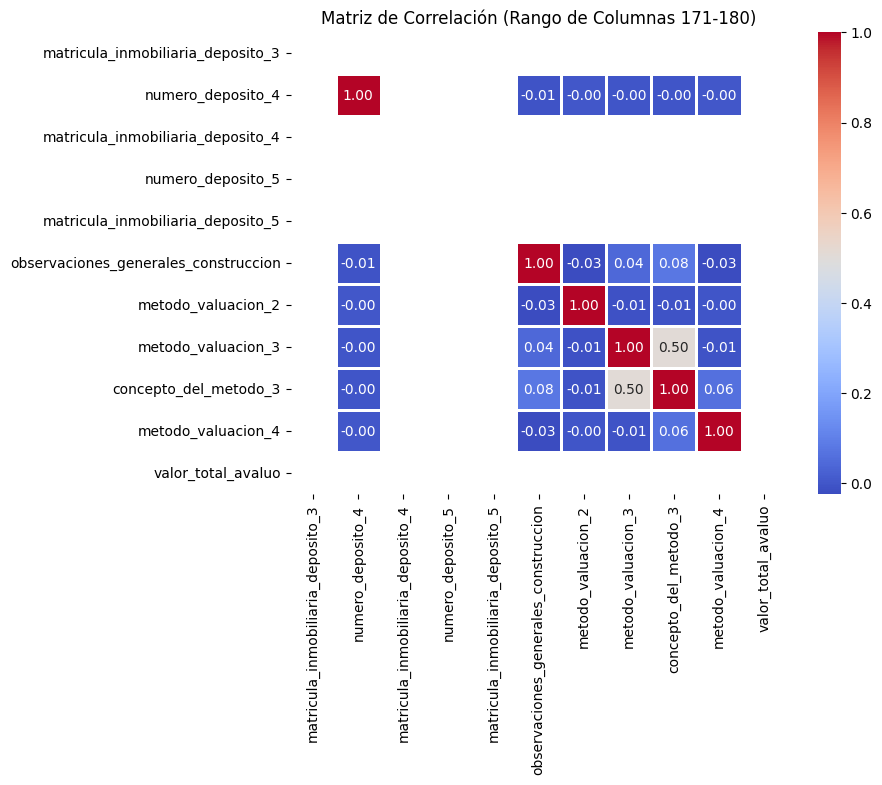

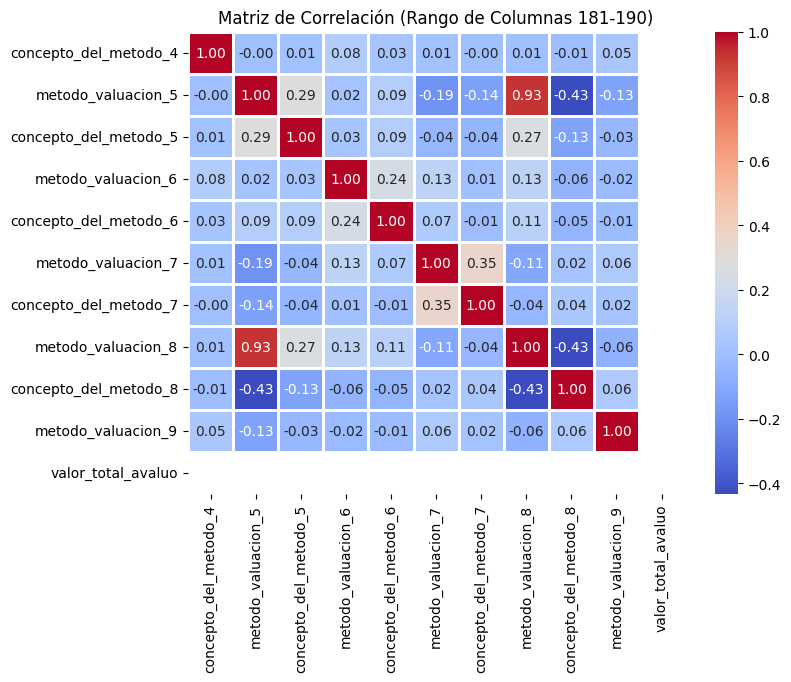

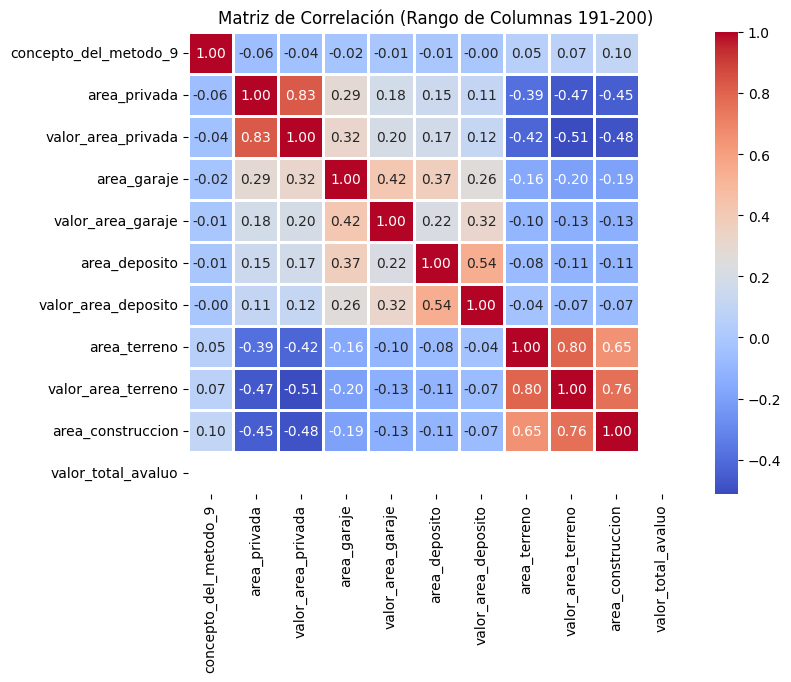

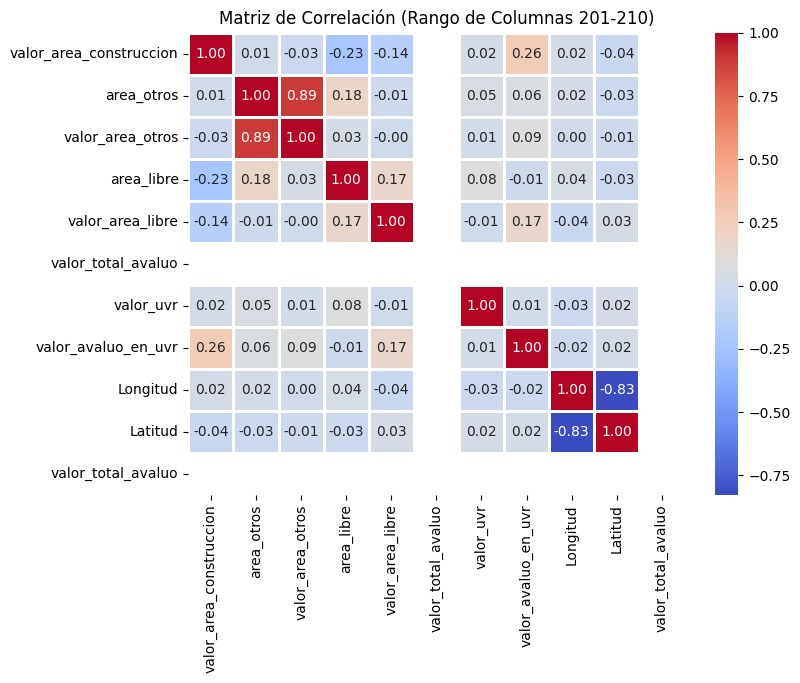

In [63]:

# Definir los rangos de columnas que deseas incluir en el análisis de correlación
column_ranges = [(1, 207)]

# Iterar sobre los rangos de columnas y realizar el reemplazo de puntos por comas
for start, end in column_ranges:
    for columna in df_clean.columns[start:end+1]:
        df_clean[columna] = df_clean[columna].astype(str).str.replace('.', ',')

# Iterar sobre las celdas de las columnas seleccionadas y convertir a numérico
for start, end in column_ranges:
    for columna in df_clean.columns[start:end+1]:
        df_clean[columna] = pd.to_numeric(df_clean[columna], errors='coerce')

# Guardar el DataFrame modificado a un nuevo archivo CSV

start_range = 1
end_range = 10
final_column = 207

# Iterar sobre los rangos de columnas y generar las gráficas de correlación
while start_range <= final_column:
    # Definir los rangos de columnas para cada iteración
    column_ranges_plot = [(start_range, end_range), (206, 206)]

    # Seleccionar las columnas para cada rango y concatenar los DataFrames resultantes
    selected_columns = []
    for start, end in column_ranges_plot:
        selected_columns.append(df_clean.iloc[:, start:end+1])
    selected_df = pd.concat(selected_columns, axis=1)

    # Filtrar solo las columnas de tipo numérico
    selected_df = selected_df.select_dtypes(include=['int64', 'int32', 'float64'])

    # Obtener la matriz de correlación
    correlation_matrix = selected_df.corr()

    # Visualizar la matriz de correlación utilizando un mapa de calor
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1)
    plt.title(f'Matriz de Correlación (Rango de Columnas {start_range}-{end_range})')
    plt.show()

    # Actualizar los rangos de columnas para la próxima iteración
    start_range += 10
    end_range += 10




In [64]:

# Cargar el archivo CSV
file_path = 'train_precios_vivienda_encoded_manual.csv'
df_clean = pd.read_csv(file_path, low_memory=False)

# Definir los rangos de columnas que deseas incluir en el análisis de correlación
column_ranges = [(1, 207)]  # Por ejemplo, tres rangos de columnas

# Iterar sobre las celdas de las columnas seleccionadas y convertir a numérico
for start, end in column_ranges:
    for columna in df_clean.columns[start:end+1]:
        df_clean[columna] = pd.to_numeric(df_clean[columna], errors='coerce')

# Seleccionar las columnas para cada rango y concatenar los DataFrames resultantes
selected_columns = []
for start_range, end_range in column_ranges:
    selected_columns.append(df_clean.iloc[:, start_range:end_range])
selected_df = pd.concat(selected_columns, axis=1)

# Obtener la matriz de correlación
correlation_matrix = selected_df.corr()

# Definir un umbral de correlación
umbral_correlacion = 0.05

# Crear una lista para almacenar las correlaciones que superen el umbral
correlaciones_superiores_umbral = []

# Iterar sobre las columnas de la matriz de correlación
for columna in correlation_matrix.columns:
    # Obtener la correlación con valor_total_avaluo para la columna actual
    correlacion = correlation_matrix.loc['valor_total_avaluo', columna]
    # Verificar si la correlación supera el umbral
    if abs(correlacion) > umbral_correlacion:
        # Agregar la correlación y el nombre de la columna a la lista
        correlaciones_superiores_umbral.append((correlacion, columna))

# Imprimir la lista de correlaciones que superan el umbral
for correlacion, columna in correlaciones_superiores_umbral:
    print(f"Correlación con {columna}: {correlacion}")


Correlación con concepto_del_metodo_3: 0.05293266580505919
Correlación con concepto_del_metodo_6: 0.08017228773164285
Correlación con valor_area_deposito: 0.053950961538400705
Correlación con valor_total_avaluo: 1.0


# **Entrenamiento y Evaluación del Modelo**

In [ ]:

# Cargar el DataFrame limpio y codificado
file_path_encoded = 'train_precios_vivienda_encoded_manual.csv'
df = pd.read_csv(file_path_encoded)

# Separar las características y la variable objetivo
X = df.drop(['valor_total_avaluo'], axis=1)  # Todas las columnas excepto 'valor_total_avaluo'
y = df['valor_total_avaluo']

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputar valores faltantes en X_train y X_test
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Inicializar el modelo Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo con los datos de entrenamiento imputados
model_rf.fit(X_train_imputed, y_train)

# Predecir sobre el conjunto de prueba
y_pred = model_rf.predict(X_test_imputed)

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R^2): {r2}")




Error cuadrático medio (MSE): 2.3021292763215343e+21
Coeficiente de determinación (R^2): -0.5929968521428788


## Optimización de Hiperparámetros con RandomizedSearchCV

In [ ]:

# Definir un subconjunto más pequeño de hiperparámetros
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Inicializar el modelo con los parámetros definidos
rf = RandomForestRegressor(random_state=42)

# Inicializar RandomizedSearchCV con los parámetros ajustados
random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid,
                                   n_iter=10,  # Número de combinaciones aleatorias a probar
                                   scoring='neg_mean_squared_error',
                                   cv=3,
                                   verbose=1,
                                   n_jobs=-1)

# Ajustar RandomizedSearchCV en los datos de entrenamiento imputados
random_search.fit(X_train_imputed, y_train)

# Obtener el mejor modelo y sus hiperparámetros
best_rf = random_search.best_estimator_
best_params = random_search.best_params_

print("Mejores hiperparámetros encontrados:")
print(best_params)

# Predecir sobre el conjunto de prueba
y_pred = best_rf.predict(X_test_imputed)

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R^2): {r2}")




Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros encontrados:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Error cuadrático medio (MSE): 2.0035035295954748e+21
Coeficiente de determinación (R^2): -0.38635777266270965


# Tratamiento de datos de puntos de interés geográfico

In [75]:
column=['longitud','latitud','categoria','nombre']
df_loc= pd.read_csv('PuntosInteres.csv',encoding='latin-1', sep=';',names=column)
df_loc.head()
# Cargar el DataFrame limpio y codificado
df = pd.read_csv('test_precios_vivienda.csv',encoding='latin-1', sep=';')


In [69]:
df['Longitud']

0               0.0
1               0.0
2       -74.643.383
3               0.0
4      -760.631.391
           ...     
412      -7.543.036
413    -740.423.059
414      -7.415.561
415    -746.104.578
416    -755.580.294
Name: Longitud, Length: 417, dtype: object

## Funciones para Limpiar Coordenadas Geográficas



In [70]:
def clean_longitude(value):
    """
    Función para limpiar y convertir un valor de longitud geográfica a un formato numérico adecuado.

    Args:
        value (float o str): Valor de longitud a limpiar.

    Returns:
        float: Valor de longitud limpio y convertido a formato numérico.
    """
    value_str = str(value).replace('.', '')
    num_digits = len(value_str.lstrip('-'))
    bool = False

    if value_str[0] == '-':
        value_str = value_str.replace('-', '')
        bool = True
        value_str = value_str[:2] + '.' + value_str[2:]

    if bool:
        value_str = float(value_str) * -1
        return value_str
    else:
        return float(value_str)

def clean_latitude(value):
    """
    Función para limpiar y convertir un valor de latitud geográfica a un formato numérico adecuado.

    Args:
        value (float o str): Valor de latitud a limpiar.

    Returns:
        float: Valor de latitud limpio y convertido a formato numérico.
    """
    value_str = str(value).replace('.', '')
    num_digits = len(value_str.lstrip('-'))

    if num_digits < 9:
        value_str = value_str[:1] + '.' + value_str[1:]
    else:
        value_str = value_str[:2] + '.' + value_str[2:]

    return float(value_str)


In [71]:
# Intentar convertir las columnas 'Latitud' y 'Longitud' a tipo string
df['Latitud']=df['Latitud'].astype(str)
df['Longitud']=df['Longitud'].astype(str)
try:
  # Intentar convertir las columnas 'Latitud' y 'Longitud' a tipo float
  df['Latitud']=df['Latitud'].astype(float)
  df['Longitud']=df['Longitud'].astype(float)
except:
  #aplicar las funciones definidas si el formato no lee los datos correctamente
  df['Latitud']=df['Latitud'].apply(clean_latitude)
  df['Longitud']=df['Longitud'].apply(clean_longitude)

  # Convertir las columnas 'Latitud' y 'Longitud' a tipo float
  df['Latitud'] = df['Latitud'].astype(float)
  df['Longitud'] = df['Longitud'].astype(float)
df.head()

,id,fecha_aprobaciÃ³n,objeto,motivo,proposito,tipo_avaluo,tipo_credito,tipo_subsidio,departamento_inmueble,municipio_inmueble,...,area_terreno,valor_area_terreno,area_construccion,valor_area_construccion,area_otros,valor_area_otros,area_libre,valor_area_libre,Longitud,Latitud
0,2243,430.144.469.211.111,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,NaN,MAGDALENA,SANTA MARTA,...,0,0,0,0,0,0,No,0,0.000000,0.000000
1,500,429.894.007.425.116,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,NaN,MAGDALENA,CIENAGA,...,136,27200000,80,44800000,0,0,0,0,0.000000,0.000000
2,12884,NaN,OriginaciÃÂ³n,CrÃÂ©dito hipotecario de vivienda,GarantÃÂ­a Hipotecaria,Hipotecario,Vivienda,NaN,TOLIMA,MELGAR,...,0,0,0,0,348.23,90539800,No,0,-74.643383,4.203572
3,4019,430.486.908.754.861,OriginaciÃ³n,ActualizaciÃ³n de garantÃ­as,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,NaN,CESAR,VALLEDUPAR,...,0,0,0,0,0,0,Si,0,0.000000,0.000000
4,11584,NaN,OriginaciÃÂ³n,CrÃÂ©dito hipotecario de vivienda,GarantÃÂ­a Hipotecaria,Hipotecario,Vivienda,NaN,HUILA,PITALITO,...,0,0,0,0,75.239.999.999.999.900,41382000,No,0,-76.063139,1.841339


In [72]:


# Inicializar un diccionario para almacenar las categorías
dic = {}

# Iterar sobre el DataFrame para comparar las coordenadas y asignar categorías
for j in range(len(df_loc)):
    for i in range(len(df)):
        if abs(df['Latitud'][i] - df_loc['latitud'][j]) <= 0.001 and abs(df['Longitud'][i] - df_loc['longitud'][j]) <= 0.001:
            try:
                # Si la categoría ya existe en la lista del diccionario, pasar
                if df_loc['categoria'][j] in dic[df['id'][i]]:
                    pass
                else:
                    # Si la categoría no existe, agregarla a la lista
                    dic[df['id'][i]].append(df_loc['categoria'][j])
            except KeyError:
                # Si la clave no existe en el diccionario, crear una nueva entrada
                dic[df['id'][i]] = [df_loc['categoria'][j]]


In [76]:
# Obtener las claves del diccionario en una lista
keys = list(dic.keys())

# Iterar sobre las claves del diccionario
for key in range(len(keys)):
    if keys[key] in df['id'].values:
        # Crear una cadena vacía para almacenar las categorías
        categorias = ''
        for element in dic[keys[key]]:
            # Concatenar cada categoría seguida de un espacio
            categorias += f'{element} '
        # Asignar la cadena de categorías a la columna 'categorias' del DataFrame
        df.loc[df['id'] == keys[key], 'categorias'] = categorias.strip()  # Usar strip() para eliminar el espacio al final

# Llenar los valores NaN en la columna 'categorias' con 'Desconocido'
df['categorias'].fillna('Desconocido', inplace=True)



## Entrenamiento de Modelo Word2Vec y Obtención de Vectores de Frases

In [77]:
# Tokenize sentences
df['tokens'] = df['categorias'].apply(word_tokenize)

# Train Word2Vec model on the tokenized sentences
model = Word2Vec(df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Function to get sentence vector
def get_sentence_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Apply function to create vectors for each sentence
df['vectors'] = df['tokens'].apply(lambda tokens: get_sentence_vector(tokens, model))

print(df[['categorias', 'vectors']])

      categorias                                            vectors
0    Desconocido  [-0.00053622725, 0.00023643136, 0.0051033497, ...
1    Desconocido  [-0.00053622725, 0.00023643136, 0.0051033497, ...
2       pharmacy  [-0.00890938, 0.0038179161, 0.0054485765, 0.00...
3    Desconocido  [-0.00053622725, 0.00023643136, 0.0051033497, ...
4    Desconocido  [-0.00053622725, 0.00023643136, 0.0051033497, ...
..           ...                                                ...
412  Desconocido  [-0.00053622725, 0.00023643136, 0.0051033497, ...
413  Desconocido  [-0.00053622725, 0.00023643136, 0.0051033497, ...
414  Desconocido  [-0.00053622725, 0.00023643136, 0.0051033497, ...
415  Desconocido  [-0.00053622725, 0.00023643136, 0.0051033497, ...
416  supermarket  [2.1475724e-05, 0.0031266583, -0.0067011123, -...

[417 rows x 2 columns]


In [ ]:
df.drop('tokens', axis=1, inplace=True)